In [1]:
from glob import glob

# How many images do we have?

GLOB = '/kaggle/input/car-camera-photos/images/images/*'

print(len(list(glob(pathname=GLOB))))

22241


This is a lot of images; we have too many for an interactive view, but maybe we can do some EDA using a static plot. Let's try.

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 512

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


In [3]:
import base64
import pandas as pd
from arrow import now
from glob import glob
from io import BytesIO
from os.path import basename
from PIL import Image

DATA = '/kaggle/input/car-camera-photos/images/images'
THUMBNAIL_SIZE = (96, 96)


def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


def get_picture_from_glob(arg: str) -> pd.Series:
    time_get = now()
    result = pd.Series(data=[basename(arg), embed(model=model, filename=arg), ], index=['name', 'value', ])
    return result

time_start = now()

df = pd.DataFrame(data=[get_picture_from_glob(arg=value) for value in list(glob(DATA + '/*.jpg'))])
print('done in {}'.format(now() - time_start))

done in 0:24:53.038567


Now let's load up the label data and merge.

In [4]:
df = df.merge(right=pd.read_csv(filepath_or_buffer='/kaggle/input/car-camera-photos/labels_train.csv'), left_on='name', right_on='frame')

We have our data and our labels; what do our classes look like?

In [5]:
df['class_id'].value_counts(normalize=True).to_dict()

{1: 0.7651768046765253,
 5: 0.09591710345452623,
 3: 0.08033623853903901,
 2: 0.047679108197513705,
 4: 0.010890745132395813}

Our data is mostly class 1, so our plot is going to be dominated by one class.

In [6]:
import arrow
from umap import UMAP

time_start = arrow.now()
umap = UMAP(random_state=2024, verbose=True, n_jobs=1, low_memory=False, n_epochs=201)
df[['x', 'y']] = umap.fit_transform(X=df['value'].apply(func=pd.Series))
print('done with UMAP in {}'.format(arrow.now() - time_start))

2024-08-11 09:40:44.941638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 09:40:44.941774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 09:40:45.122373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


UMAP(low_memory=False, n_epochs=201, n_jobs=1, random_state=2024, verbose=True)
Sun Aug 11 09:41:16 2024 Construct fuzzy simplicial set
Sun Aug 11 09:41:16 2024 Finding Nearest Neighbors
Sun Aug 11 09:41:16 2024 Building RP forest with 23 trees
Sun Aug 11 09:41:32 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	Stopping threshold met -- exiting after 4 iterations
Sun Aug 11 09:42:05 2024 Finished Nearest Neighbor Search
Sun Aug 11 09:42:09 2024 Construct embedding


/opt/conda/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/conda/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/conda/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/conda/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely d

Epochs completed:   0%|            0/201 [00:00]

	completed  0  /  201 epochs
	completed  20  /  201 epochs
	completed  40  /  201 epochs
	completed  60  /  201 epochs
	completed  80  /  201 epochs
	completed  100  /  201 epochs
	completed  120  /  201 epochs
	completed  140  /  201 epochs
	completed  160  /  201 epochs
	completed  180  /  201 epochs
	completed  200  /  201 epochs
Sun Aug 11 11:58:34 2024 Finished embedding
done with UMAP in 2:17:36.933478


<Axes: xlabel='x', ylabel='y'>

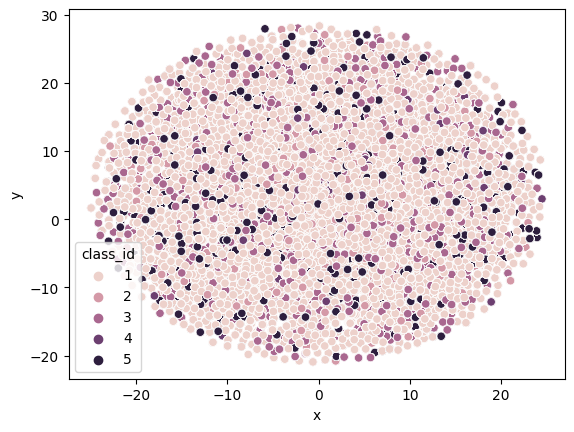

In [7]:
import seaborn as sns

sns.scatterplot(data=df, x='x', y='y', hue='class_id')